In [1]:
# trainloader length: 2700
# testloader length: 323

In [2]:
from collections import Counter
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchtext
import os
import traceback
%load_ext autoreload
%autoreload 2

In [3]:
from torchtext.experimental.datasets import SQuAD1
from torchtext.data.utils import get_tokenizer
# data_dir = '.data'
# data_names = ['dev-v1.1.json', 'train-v1.1.json']
# for data_name in data_names:
#     if not os.path.isfile(os.path.join(data_dir, data_name)):
#         print('download')
#         train, dev = SQuAD1()
#         break
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
# dataset shape: (paragraph, question, answer, span)
trainset, devset = SQuAD1(tokenizer=tokenizer)

100%|██████████| 87599/87599 [00:22<00:00, 3900.56lines/s]


In [4]:
vocab = trainset.get_vocab()

In [5]:
# import re
# errors = 0
# print('length of vocab before filtering:', len(vocab.stoi))
# for key, value in list(vocab.stoi.items()):
#     if re.search('\n', key) or re.search(' ', key):
#         errors += 1
#         print(key)
#         vocab.stoi.pop(key)
#         vocab.itos.pop(value)
#         vocab.freqs.pop(key)
#         # vocab.freqs[key] -= 1
#         # if vocab.freqs[key] < 1:
#         #     vocab.freqs.pop(key)
#
# print(errors)
# print('length of vocab after filtering:', len(vocab.stoi))

In [6]:
# trainset, devset = SQuAD1(vocab=vocab)

In [7]:
def remove_large_text(data):
    return data[0] <= 400

def check_train_data(data):
    # data might be wrong because of spacy tokenizer
    p_length, q_length, idx, paragraph, question, answer, span = data
    if span[0][0] > p_length or span[0][1] > p_length:
        return False
    if paragraph[span[0][0]] == answer[0][0] and paragraph[span[0][1]] == answer[0][-1]:
        return True
    return False

def check_dev_data(data):
    p_length, q_length, idx, paragraph, question, answers, spans = data
    if len(spans) != 3 or len(answers) != 3:
        return False
    else:
        for span, answer in zip(spans, answers):
            if span[0] > p_length or span[1] > p_length:
                return False
            if paragraph[span[0]] != answer[0] or paragraph[span[1]] != answer[-1]:
                return False
        return True

In [8]:
train_data = [(len(paragraph), len(question), idx, paragraph, question, answer, span)
            for idx, (paragraph, question, answer, span) in enumerate(trainset)]
dev_data = [(len(paragraph), len(question), idx, paragraph, question, answer, span)
            for idx, (paragraph, question, answer, span) in enumerate(devset)]

train_data = list(filter(remove_large_text, train_data))
dev_data = list(filter(remove_large_text, dev_data))

train_data = list(filter(check_train_data, train_data))
dev_data = list(filter(check_dev_data, dev_data))


train_data.sort() # sort by length and pad sequences with similar lengths
dev_data.sort()
# paragraph, question: tensor of indices of words, use itos to get word
print(len(train_data))
print(len(dev_data))
# Generate the pad id
pad_id = vocab['<pad>']

86412
8295


In [9]:
# print(train_data[0][3])
# for idx in train_data[0][3]:
#     print(train.get_vocab().itos[idx], sep=' ')

In [10]:
def pad_data(data):
    # Find max length of the mini-batch
    # train.get_vocab()['pad'], dev.get_vocab()['pad'] is equal to 22949
    max_p_len = max(list(zip(*data))[0])
    max_q_len = max(list(zip(*data))[1])
    paragraph_list = list(zip(*data))[3]
    question_list = list(zip(*data))[4]
    answer_list = list(zip(*data))[5]
    span_list = list(zip(*data))[6]
    padded_paragraphs = torch.stack([torch.cat((paragraph,
            torch.LongTensor([pad_id] * (max_p_len - len(paragraph))))) \
            for paragraph in paragraph_list])
    padded_questions = torch.stack([torch.cat((question,
            torch.tensor([pad_id] * (max_q_len - len(question))).long())) \
            for question in question_list])
    paragraph_pad_mask = torch.zeros_like(padded_paragraphs).masked_fill(padded_paragraphs == pad_id, 1)
    question_pad_mask = torch.zeros_like(padded_questions).masked_fill(padded_questions == pad_id, 1)

    return padded_paragraphs, padded_questions, span_list, answer_list, \
           paragraph_pad_mask, question_pad_mask

In [11]:
BATCH_SIZE = 64
from torch.utils.data import DataLoader
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_data)
testloader = DataLoader(dev_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_data)

In [12]:
for i, (p, q, a, s) in enumerate(devset):
    print(a,s)
    nps = s[0].numpy()
    tokens = tokenizer(trainset.data[i][0])
    print(tokens[int(nps[0])])
    print(tokens[nps[1]])
    # print(tokens[a[0].numpy().item()])
    if i > 0:
        break

[tensor([12163, 56789]), tensor([12163, 56789]), tensor([12163, 56789])] [tensor([33, 34]), tensor([33, 34]), tensor([33, 34])]
facing
it
[tensor([  881, 20129]), tensor([  881, 20129]), tensor([  881, 20129])] [tensor([44, 45]), tensor([44, 45]), tensor([44, 45])]
upraised
with


In [13]:
for idx, (padded_paragraphs, padded_questions, span_list, answer_list,
           paragraph_pad_mask, question_pad_mask) in enumerate(trainloader):
    # print(idx, padded_paragraphs, padded_questions, span_list, answer_list,
    #        paragraph_pad_mask, question_pad_mask)
    # print(padded_paragraphs.masked_fill(paragraph_pad_mask == 1, -1))
    if idx > 0:
        break

In [14]:
# print(trainset.get_vocab()['pad'], dev.get_vocab()['pad'])

In [15]:
glove_vec = torchtext.vocab.GloVe(name='840B', dim=300)

In [16]:
def build_word_embedding(vocab, pre_trained_emb_vec):
    # print(pre_trained_emb_vec.dim)
    weights_matrix = np.zeros((len(vocab), pre_trained_emb_vec.dim))
    words_found = 0
    no_word = 0
    for i, (word, _) in enumerate(vocab.freqs.most_common()):
        try:
            word_index = pre_trained_emb_vec.stoi[word]
            weights_matrix[i] = pre_trained_emb_vec[word_index]
            words_found += 1
        except:
            no_word += 1 # no such word in pre_trained_embedding: zero vector
    print('words not found:', no_word)
    print('words found:', words_found)
    return torch.FloatTensor(weights_matrix)

In [17]:
# for key, value in vocab.freqs.items():
#     if re.search(' ', key):
#         print(key, value)
# for i, word in enumerate(vocab.freqs.most_common()):
#     print(word)
#     if i > 5:
#         break

In [18]:
word_emb_table = build_word_embedding(vocab, glove_vec)

words not found: 17435
words found: 86591


In [19]:
# glove_vec.vectors[:5]

In [20]:
# not using now
# import spacy
# nlp = spacy.load('en_core_web_sm', disable=['parser','ner',])
#
# def exact_match(paragraphs_indices, questions_indices, vocab):
#     # process one paragraph batch, one question batch
#     # print(paragraphs_indices.size())
#     # print(questions_indices.size())
#     #
#     # j = 0
#     # for (paragraph_indices, question_indices) in \
#     #         zip(paragraphs_indices, questions_indices):
#     #     j += 1
#     # print('j:',j)
#     exact_match_table = np.zeros((len(paragraphs_indices), len(paragraphs_indices[0]), 3))
#     # print(exact_match_table.shape)
#
#     for i, (paragraph_indices, question_indices) in \
#             enumerate(zip(paragraphs_indices, questions_indices)):
#         # print(paragraphs_indices)
#         # print(paragraphs_indices.size())
#         # paragraph_processed = nlp(paragraph_sentence)
#         # question_lemmas = [lem.lemma_ for lem in question_processed]
#         for j, paragraph_index in enumerate(paragraph_indices):
#             paragraph_word = vocab.itos[paragraph_index]
#             if paragraph_word == '<pad>':
#                 # print('got pad')
#                 continue
#             em_tensor = torch.LongTensor([0, 0, 0])
#             # original
#             if paragraph_index in question_indices:
#                 em_tensor[0] = 1
#             # lemma
#             if vocab.stoi[nlp(paragraph_word)[0].lemma_] in question_indices:
#                 em_tensor[1] = 1
#             # uncased
#             if vocab.stoi[paragraph_word.lower()] and \
#                     vocab.stoi[paragraph_word.lower()] in question_indices:
#                 em_tensor[2] = 1
#             exact_match_table[i][j] = em_tensor
#
#     return torch.LongTensor(exact_match_table)

In [21]:
class AlignedQuestionEmbedding(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.relu = nn.ReLU()
        self.linear = nn.Linear(input_dim, input_dim)

    def forward(self, paragraph, question, question_pad_mask):

        p = self.relu(self.linear(paragraph))

        q = self.relu(self.linear(question))
        q = q.permute(0, 2, 1)

        dot_product = torch.bmm(p, q)
        # print(dot_product.size())
        # print(question_pad_mask.size())
        question_mask_expand = question_pad_mask.unsqueeze(1).expand(dot_product.size())
        dot_product = dot_product.masked_fill(question_mask_expand == 1, -float('inf'))

        dot_product_flatten = dot_product.view(-1, question.size(1))

        attn_score = F.softmax(dot_product_flatten, dim=1)
        attn_score = attn_score.view(-1, paragraph.shape[1], question.shape[1])

        aligned_embedding = torch.bmm(attn_score, question)
        return aligned_embedding

In [22]:
class MultiLayerBiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, nlayers, dropout):
        super().__init__()
        self.nlayers = nlayers

        self.lstms = nn.ModuleList()
        self.dropout = nn.Dropout(p=dropout)
        self.lstms.append(nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True))
        for i in range(1, nlayers):
            self.lstms.append(nn.LSTM(hidden_size * 2, hidden_size,
                                      batch_first=True, bidirectional=True))

    def forward(self, x):
        # x = self.dropout(x)
        lstm_output, (_, _) = self.lstms[0](x)
        hidden_states = [lstm_output]
        # print(lstm_output.size(), hidden_state.size(), cell_state.size())
        for i in range(1, self.nlayers):
            # lstm_output = self.dropout(lstm_output)
            lstm_output, (_, _) = self.lstms[i](lstm_output)
            # print(lstm_output.size(), hidden_state.size(), cell_state.size())
            hidden_states.append(lstm_output)

        output = torch.cat(hidden_states, dim=2)

        output = self.dropout(output)
        return output


In [23]:
class QuestionEncoding(nn.Module):
    def __init__(self, input_size, hidden_size, nlayers, dropout):
        super().__init__()
        self.lstm_output_size = hidden_size * 6
        self.linear = nn.Linear(self.lstm_output_size, 1)
        self.lstm = MultiLayerBiLSTM(input_size, hidden_size, nlayers, dropout)
        # biLSTM output size: hidden size * 6
    def forward(self, x, question_mask):
        try:
            x = self.lstm(x)
            b = x.view(-1, self.lstm_output_size)
            b = self.linear(b) # attention score
            b = b.view(question_mask.shape[0], -1)
            # print(x.size(), question_mask.size())
            b = b.masked_fill(question_mask == 1, -float('inf')) # masking
            b = F.softmax(b, dim=1)

            b = b.unsqueeze(1)
            # print(x.size(), x_lstm.size())
            encoding = torch.bmm(b, x)
            encoding = encoding.squeeze(1)
            return encoding
        except:
            print('question mask size:', question_mask.size())
            print('x size:', x.size())
            print('b size:', b.size())
            print(traceback.print_exc())

In [24]:
class PredictionLayer(nn.Module):
    def __init__(self, p_size, q_size):
        super().__init__()
        self.linear = nn.Linear(q_size, p_size)

    def forward(self, paragraph, question, paragraph_mask):
        Wq = self.linear(question)
        Wq = Wq.unsqueeze(2)
        pWq = paragraph.bmm(Wq)
        pWq = pWq.squeeze(2)
        pWq = pWq.masked_fill(paragraph_mask == 1, -float('inf'))
        return pWq

In [25]:
def fixate_embedding(grad):
    grad[1000:] = 0
    return grad

class DocumentReader(nn.Module):
    def __init__(self, hidden_size, embedding_size, nlayers, dropout, device):
        super().__init__()
        self.device = device

        self.word_embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word_emb_table).to(device), freeze=False)
        self.word_embedding_layer.weight.register_hook(fixate_embedding)
        # print(embedding_size)
        self.aligned_embedding_layer = AlignedQuestionEmbedding(embedding_size)
        # self.paragraph_lstm = MultiLayerBiLSTM(embedding_size * 2 + 3, hidden_size, nlayers, dropout)
        self.paragraph_lstm = MultiLayerBiLSTM(embedding_size * 2, hidden_size, nlayers, dropout)

        self.question_encoder = QuestionEncoding(embedding_size, hidden_size, nlayers, dropout)

        self.prediction_layer_start = PredictionLayer(hidden_size * nlayers * 2,
                                                          hidden_size * nlayers * 2)
        self.prediction_layer_end = PredictionLayer(hidden_size * nlayers * 2,
                                                        hidden_size * nlayers * 2)

        self.dropout = nn.Dropout(dropout)
    def forward(self, paragraph, question, paragraph_mask, question_mask):
        # em_embedding = exact_match(paragraph, question, vocab)
        # print(em_embedding.size())
        p_word_embedding = self.word_embedding_layer(paragraph)
        q_word_embedding = self.word_embedding_layer(question)
        p_word_embedding = self.dropout(p_word_embedding)
        q_word_embedding = self.dropout(q_word_embedding)
        aligned_embedding = self.aligned_embedding_layer(p_word_embedding, q_word_embedding, question_mask)
        # print(p_word_embedding.size())
        # print(aligned_embedding.size())
        paragraph_embeddings = torch.cat([p_word_embedding, aligned_embedding], dim=2)

        # paragraph_embeddings = torch.cat([em_embedding.to(device), p_word_embedding.to(device), aligned_embedding.to(device)], dim=2)
        paragraph_encoding = self.paragraph_lstm(paragraph_embeddings)
        # print(question.size(), question_mask.size())
        question_encoding = self.question_encoder(q_word_embedding, question_mask)

        prediction_start = self.prediction_layer_start(paragraph_encoding, question_encoding, paragraph_mask)
        prediction_end = self.prediction_layer_end(paragraph_encoding, question_encoding, paragraph_mask)

        return prediction_start, prediction_end

In [26]:
HIDDEN_SIZE = 128
EMB_SIZE = 300
NLAYERS = 3
DROPOUT = 0.3
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DocumentReader(HIDDEN_SIZE,
                       EMB_SIZE,
                       NLAYERS,
                       DROPOUT,
                       device).to(device)

In [27]:
# from torch.utils.tensorboard import SummaryWriter
#
# writer = SummaryWriter('runs/myDrQA')

In [28]:
# dataiter = iter(trainloader)
# dataiter_next = dataiter.next()
# print(dataiter_next)
# (p, q, a, s, p_mask, q_mask) = dataiter.next()
# writer.add_graph(model, p, p_mask, q_mask)
# writer.close()

In [29]:
optimizer = torch.optim.Adamax(model.parameters())

In [30]:
from time import time
def train(model, train_dataset):
    '''
    Trains the model.
    '''

    print("Start training ........")

    train_loss = 0.

    # put the model in training mode
    model.train()
    start_time = time()
    # iterate through training data
    try:
        for i, (paragraphs, questions, span_list, answer_list,
                paragraph_mask, question_mask) in enumerate(train_dataset):
            # if i < 575:
            #     continue
            if i % 500 == 0:
                print(f"Starting batch: {i}, time: {time() - start_time}")


            # place the tensors on GPU
            paragraphs = paragraphs.to(device)
            paragraph_mask = paragraph_mask.to(device)
            questions = questions.to(device)
            question_mask = question_mask.to(device)
            # span_list = span_list.to(device)

            # forward pass, get the predictions
            preds = model(paragraphs, questions, paragraph_mask, question_mask)

            start_pred, end_pred = preds

            # print('preds:', start_pred, end_pred)
            # separate labels for start and end position
            span_start = []
            span_end = []
            for span in span_list:
                span_start.append(span[0][0].item())
                span_end.append(span[0][1].item())

            # print('span:', span_start, span_end)
            span_start = torch.LongTensor(span_start).to(device)
            span_end = torch.LongTensor(span_end).to(device)
            # calculate loss
            loss = F.cross_entropy(start_pred, span_start) + F.cross_entropy(end_pred, span_end)

            # backward pass, calculates the gradients
            loss.backward()

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)

            # update the gradients
            optimizer.step()

            # zero the gradients to prevent them from accumulating
            optimizer.zero_grad()

            # ...학습 중 손실(running loss)을 기록하고
            # writer.add_scalar('training loss',
            #                 train_loss / 500,
            #                 epoch * len(trainloader) + i)
            train_loss += loss.item()
    except Exception as e:
        print(f'sizes of pred:{start_pred.size()} / span:{span_start.size()}')
        print(f'span_start: {span_start[23]}\nspan_end: {span_end[23]}')
        print(f'i: {i}')
        print(f'paragraph: {paragraphs}')
        bad_p = paragraphs.numpy()[23]
        bad_q = questions.numpy()[23]
        bad_p_text = [vocab.itos[pi] for pi in bad_p]
        bad_q_text = [vocab.itos[qi] for qi in bad_q]
        bad_p_text = ' '.join(bad_p_text)
        bad_q_text = ' '.join(bad_q_text)

        print(bad_p_text)
        print(bad_q_text)
        print(f'paragraph size: {paragraphs.size()}, question size: {questions.size()}')
        print(traceback.format_exc())


    return train_loss / len(train_dataset)

In [31]:
# %time train_loss = train(model, trainloader)

In [32]:
from sklearn.metrics import f1_score
def validate(model, test_dataset):
    '''
    Validates the model.
    '''

    print("Start validation ........")

    val_loss = 0.
    emScore = 0
    f1Score = 0
    # put the model in eval mode
    model.eval()
    start_time = time()
    # iterate through training data
    for i, (paragraphs, questions, span_list, answer_list,
            paragraph_mask, question_mask) in enumerate(test_dataset):
        if i % 500 == 0:
            print(f"Starting batch: {i}, time: {time() - start_time}")


        # place the tensors on GPU
        paragraphs = paragraphs.to(device)
        paragraph_mask = paragraph_mask.to(device)
        questions = questions.to(device)
        question_mask = question_mask.to(device)
        # span_list = span_list.to(device)

        # forward pass, get the predictions
        preds = model(paragraphs, questions, paragraph_mask, question_mask)

        start_pred, end_pred = preds
        # print('preds:', start_pred, end_pred)
        start_pred_argmax = torch.argmax(start_pred, dim=1)
        end_pred_argmax = torch.argmax(start_pred, dim=1)

        # separate labels for start and end position
        span_start = []
        span_end = []
        true_answers_list = []
        my_answers = []
        for paragraph, spans, answers, sp, ep in \
                zip(paragraphs, span_list, answer_list, start_pred_argmax, end_pred_argmax):
            span_start.append([span[0].item() for span in spans][:3])
            span_end.append([span[1].item() for span in spans][:3])
            true_answers_list.append([ans2txt(answer) for answer in answers])
            my_answers.append(span2txt([sp, ep + 1], paragraph))
        with torch.no_grad():
            # print('span:', span_start, span_end)
            try:
                span_start = torch.LongTensor(span_start).to(device)
                span_end = torch.LongTensor(span_end).to(device)
                # calculate loss
                loss = F.cross_entropy(start_pred, span_start.t()[0]) + F.cross_entropy(end_pred, span_end.t()[0])

                val_loss += loss.item()

                emScore += em_batch(my_answers, true_answers_list)
                f1Score += f1_batch(my_answers, true_answers_list)
            except:
                print('start pred:', start_pred)
                print('start pred shape:', start_pred.shape)
                print('span_list:', span_list)
                print('span_list length:', len(span_list))
                print('span_start:', span_start)
                print('span_start shape:', np.asarray(span_start).shape)
                print('span_end:', span_end)
                print(traceback.format_exc())

    return val_loss / len(test_dataset), emScore / len(test_dataset), f1Score / len(test_dataset)

In [33]:
import re
from string import punctuation
def normalize_answer(s):
    '''
    Performs a series of cleaning steps on the ground truth and
    predicted answer.
    '''
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))
def em_batch(my_answers, true_answers_list):
    # true_answers_list: batch size * 3
    em = 0
    for my_answer, true_answers in zip(my_answers, true_answers_list):
        for true_answer in true_answers:
            if my_answer == true_answer:
                em += 1
                break
    return em / BATCH_SIZE

def f1_batch(my_answers, true_answers_list):
    f1Batch = 0
    for my_answer, true_answers in zip(my_answers, true_answers_list):
        f1_single = 0
        for true_answer in true_answers:
            my_answer_split = my_answer.split()
            true_answer_split = true_answer.split()
            common = Counter(my_answer_split) & Counter(true_answer_split)
            num_same = sum(common.values())
            if num_same == 0:
                continue
            precision = num_same / len(my_answer_split)
            recall = num_same / len(true_answer_split)
            f1_single += (2 * precision * recall) / (precision + recall)
        f1Batch += f1_single / len(true_answers)
    return f1Batch / BATCH_SIZE

In [34]:
def span2txt(span, paragraph):
    # print(span[0])
    my_answer = paragraph[span[0].item() : span[1].item() + 1]
    return ans2txt(my_answer)
def ans2txt(answer):
    words = []
    for a_index in answer:
        words.append(vocab.itos[a_index.item()])
    return normalize_answer(' '.join(words))


In [35]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
best_val_loss = 100
path = 'best.pt'
if os.path.isfile(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [36]:
train_losses = []
val_losses = []
em_scores = []
f1_scores = []
for epoch in range(10):
    print(f'Staring epoch {epoch}')
    start_time = time()

    train_loss = train(model, trainloader)
    val_loss, emScore, f1Score = validate(model, testloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    em_scores.append(em_scores)
    f1_scores.append(f1_scores)

    if best_val_loss > val_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, path)
    end_time = time()

    time_elapsed = end_time - start_time
    print(f'train_loss: {train_loss}, val_loss: {val_loss}')
    print(f'em_score: {emScore * 100}, f1_score: {f1Score * 100}')
    print(f'End epoch {epoch}, elapsed time: {time_elapsed}')

Staring epoch 0
Start training ........
Starting batch: 0, time: 0.007999420166015625
Starting batch: 500, time: 111.88347554206848
Starting batch: 1000, time: 232.55780577659607
Start validation ........
Starting batch: 0, time: 0.0039997100830078125
train_loss: 7.522219305299636, val_loss: 6.809384606434748
em_score: 11.466346153846153, f1_score: 20.633015914072914
End epoch 0, elapsed time: 329.16336488723755
Staring epoch 1
Start training ........
Starting batch: 0, time: 0.008033990859985352
Starting batch: 500, time: 126.66039276123047
Starting batch: 1000, time: 255.39749121665955
Start validation ........
Starting batch: 0, time: 0.003994464874267578
train_loss: 6.385463044345158, val_loss: 5.948482212653527
em_score: 15.805288461538462, f1_score: 28.596841912320713
End epoch 1, elapsed time: 354.76946210861206
Staring epoch 2
Start training ........
Starting batch: 0, time: 0.015001773834228516
Starting batch: 500, time: 132.3486087322235
Starting batch: 1000, time: 262.517054

In [37]:
# val_loss, emScore, f1Score = validate(model, testloader)
# print(f'train_loss: {train_loss}, val_loss: {val_loss}')
# print(f'em_score: {emScore * 100}, f1_score: {f1Score * 100}')

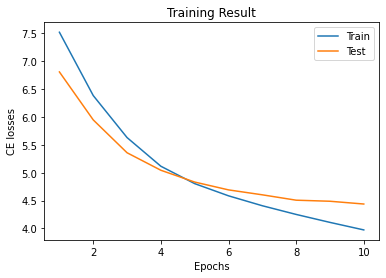

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot([i for i in range(1, 11)], train_losses)
plt.plot([i for i in range(1, 11)], val_losses)
plt.xlabel('Epochs')
plt.ylabel('CE losses')
plt.title('Training Result')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
# %matplotlib inline
# from matplotlib import pyplot as plt
plt.plot([i for i in range(1, 11)], em_scores)
plt.plot([i for i in range(1, 11)], f1_scores)
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('Scores on SQuAD 1.1')
plt.legend(['EM', 'F1'])
plt.show()

In [ ]:
# idx = 0
# for i, t_data in enumerate(testloader):
#     idx = i
# print(idx)

In [ ]:
# (p, q, s, a, p_mask, q_mask), p 길이 점점 증가
# p, q: tensor, batch size * length
# s: tuple of tensors, batch size
# a:
dataiter = iter(trainloader)
dataiter_next = dataiter.next()
dataiter_next[0].shape

In [ ]:
dataiter = iter(trainloader)
for i in range(100):
    dataiter_100 = dataiter.next()
dataiter_100[1].shape

In [ ]:
paragraphs, questions, span_list, answer_list, paragraph_mask, question_mask = dataiter_next
model_ex = DocumentReader(HIDDEN_SIZE,
                       EMB_SIZE,
                       NLAYERS,
                       DROPOUT,
                       device).to(device)
model_ex.train()
paragraphs = paragraphs.to(device)
paragraph_mask = paragraph_mask.to(device)
questions = questions.to(device)
question_mask = question_mask.to(device)
# span_list = span_list.to(device)

# forward pass, get the predictions
preds = model(paragraphs, questions, paragraph_mask, question_mask)

start_pred, end_pred = preds

In [ ]:
# start_pred.shape
# start_pred_argmax = torch.argmax(start_pred, dim=1)
# print(start_pred_argmax)
# print(span_list)
# print(span_list[0][0].item())

In [ ]:
i = 0
for p, s, a in zip(paragraphs, span_list, answer_list):
    i += 1
    if i < 3:
        print(p)
        print(s)
        print(a)

In [ ]:
# em_score = 0
# for i, (p, s, a) in enumerate(list(zip(paragraphs, span_list, answer_list))):
#     i += 1
#     # print(i)
#     if i < 3:
#         # print(p)
#         # print(s)
#         # print(a)
#         em_score += em_func(p, a[0], s)
# print(em_score)